In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import requests
import os
from urllib import request, error
import urllib
import imageio
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import torch.utils.data as data_utils
from collections import Counter
from PIL import Image
import gzip
import operator

### Load image & label arrays

In [2]:
f = gzip.open('images64All.npy.gz','r')
allImages = np.array(np.load(f))

f = gzip.open('landmark_id64All.npy.gz','r')
landmark_id = np.array(np.load(f))
numClasses = len(np.unique(landmark_id))
print('Class count')
for key, value in Counter(landmark_id).items():
    print(' ', key, ': ' ,value)
le = preprocessing.LabelEncoder()
le.fit(landmark_id)
landmark_labels = le.transform(landmark_id)

Class count
  9633 :  3672
  6051 :  3710
  6599 :  3808
  9779 :  3723
  2061 :  3776
  5554 :  3714
  6651 :  3798
  5376 :  3449
  6696 :  3454
  4352 :  3870
  2743 :  3833
  13526 :  3854
  1553 :  3775
  10900 :  3373
  8063 :  3298
  8429 :  3789


1553 : 


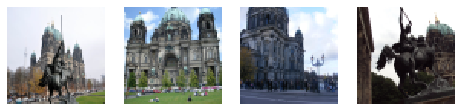

2061 : 


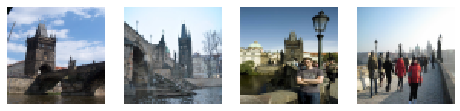

2743 : 


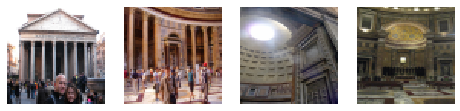

4352 : 


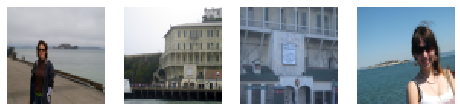

5376 : 


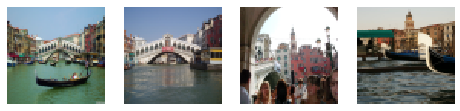

5554 : 


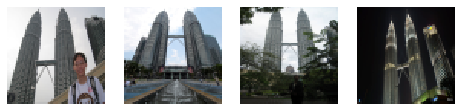

6051 : 


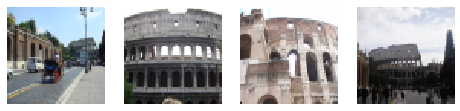

6599 : 


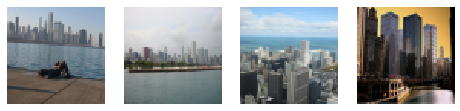

6651 : 


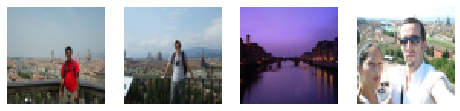

6696 : 


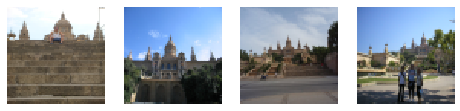

8063 : 


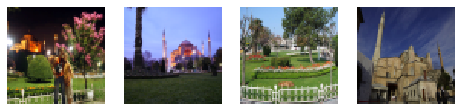

8429 : 


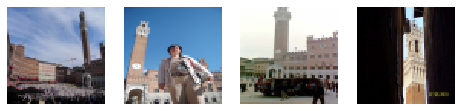

9633 : 


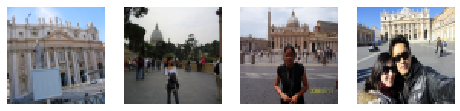

9779 : 


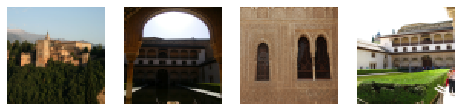

10900 : 


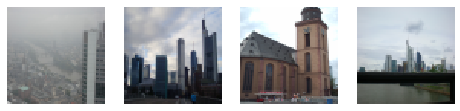

13526 : 


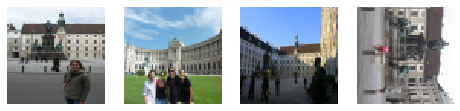

In [5]:
# print images from each class
for i in range(numClasses):
    print(np.unique(landmark_id)[i], ': ')
    index_landmark = np.where(landmark_id == np.unique(landmark_id)[i])[0]
    f, axarr = plt.subplots(1,4, figsize=(8,8))
    for j in range(4): # print 4 images per class
        axarr[j].imshow(np.transpose(allImages[index_landmark[j]]/ 2 + 0.5, (1, 2, 0)))
        axarr[j].axis('off')
    plt.show()

In [3]:
imagesTrain, imagesTest, landmark_id_train, landmark_id_test = train_test_split(allImages, landmark_labels, test_size=0.2, shuffle=True)
print('Train shape: ', imagesTrain.shape)
print('Test shape: ', imagesTest.shape)

Train shape:  (47116, 3, 64, 64)
Test shape:  (11780, 3, 64, 64)


In [4]:
batchSize = 8

featuresTrain = torch.Tensor(imagesTrain)
targetsTrain = torch.Tensor(landmark_id_train)
targetsTrain = targetsTrain.int()
trainset = data_utils.TensorDataset(featuresTrain, targetsTrain)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

featuresTest = torch.Tensor(imagesTest)
targetsTest = torch.Tensor(landmark_id_test)
targetsTest = targetsTest.int()
testset = data_utils.TensorDataset(featuresTest, targetsTest)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = le.classes_
print('Classes:', classes)
all_losses = []

Classes: [ 1553  2061  2743  4352  5376  5554  6051  6599  6651  6696  8063  8429
  9633  9779 10900 13526]


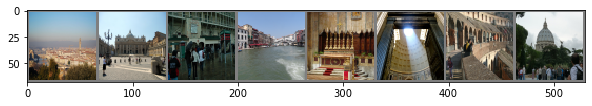

Labels:
 6651  9633  4352  5376  2743  2743  6051  9633


In [5]:
# The function to show an image, CODE FROM COGS 181 HW5
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = dataiter.next()
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print('Labels:')
print(' '.join('%5s' % classes[labels[j]] for j in range(batchSize)))

### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


### 2 Layer CNN

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.fc1 = nn.Linear(20*16*16, 100)
        self.fc2 = nn.Linear(100, numClasses)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=5120, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=16, bias=True)
)

### 3 Layer CNN

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 30, 3, 1, 1)
        self.fc1 = nn.Linear(30*8*8, 100)
        self.fc2 = nn.Linear(100, numClasses)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 30*8*8)
        x = (F.relu((self.fc1(x))))
        x = self.fc2(x)
        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=16, bias=True)
)

### 4 Layer CNN

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 30, 3, 1, 1)
        self.conv4 = nn.Conv2d(30, 40, 3, 1, 1)
        self.fc1 = nn.Linear(40*4*4, 100)
        self.fc2 = nn.Linear(100, numClasses)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))
        x = x.view(-1, 40*4*4)
        x = self.drop(F.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=640, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=16, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

### 5 layer CNN

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 30, 3, 1, 1)
        self.conv4 = nn.Conv2d(30, 40, 3, 1, 1)
        self.conv5 = nn.Conv2d(40, 50, 3, 1, 1)
        self.fc1 = nn.Linear(50*2*2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, numClasses)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))
        x = self.pool(F.leaky_relu(self.conv5(x)))
        x = x.view(-1, 50*2*2)
        x = F.leaky_relu(self.fc1(self.drop(x)))
        x = F.leaky_relu(self.fc2(self.drop(x)))
        x = F.leaky_relu(self.fc3(x))
#         x = F.leaky_relu(self.fc1(x))
#         x = F.leaky_relu(self.fc2(x))
#         x = F.leaky_relu(self.fc3(x))
        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(40, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=16, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

### Optimizer and Loss Function

In [54]:
loss_func = nn.CrossEntropyLoss()  
# opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
opt = optim.Adam(net.parameters(), lr=0.001)
# opt = optim.Adagrad(net.parameters())
# opt = optim.RMSprop(net.parameters())

### Training Procedure

In [55]:
# CODE FROM COGS 181 HW5
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.
print_epoch = 5000  #10000 Print epoch.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        labels = labels.long()
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            if i % print_epoch == print_epoch - 1:
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
all_losses.append(avg_losses)
            
print('Finished Training.')

[epoch: 0, i:  4999] avg mini-batch loss: 2.104
[epoch: 1, i:  4999] avg mini-batch loss: 1.606
[epoch: 2, i:  4999] avg mini-batch loss: 1.394
[epoch: 3, i:  4999] avg mini-batch loss: 1.102
[epoch: 4, i:  4999] avg mini-batch loss: 1.064
[epoch: 5, i:  4999] avg mini-batch loss: 0.993
[epoch: 6, i:  4999] avg mini-batch loss: 0.988
[epoch: 7, i:  4999] avg mini-batch loss: 0.818
[epoch: 8, i:  4999] avg mini-batch loss: 0.820
[epoch: 9, i:  4999] avg mini-batch loss: 0.872
Finished Training.


###### Training Loss Curve

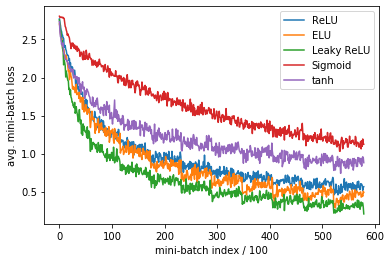

In [112]:
# different activation functions with 4 layer CNN
plt.plot(all_losses[2], label='ReLU')
plt.plot(all_losses[4], label='ELU')
plt.plot(all_losses[5], label='Leaky ReLU')
plt.plot(avg_losses, label='Sigmoid')
plt.plot(all_losses[7], label='tanh')
plt.legend()
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

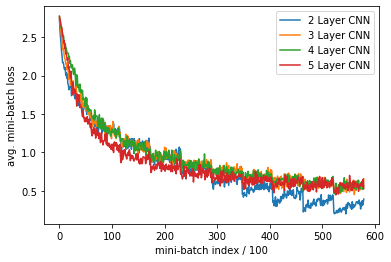

In [74]:
plt.plot(all_losses[0], label='2 Layer CNN')
plt.plot(all_losses[1], label='3 Layer CNN')
plt.plot(all_losses[2], label='4 Layer CNN')
plt.plot(all_losses[3], label='5 Layer CNN')
plt.legend()
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

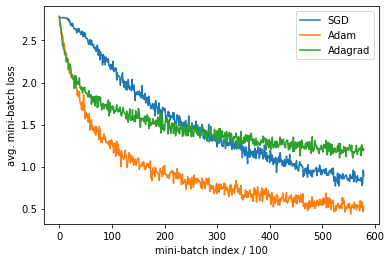

In [31]:
plt.plot(all_losses[0], label='SGD')
plt.plot(all_losses[1], label='Adam')
plt.plot(all_losses[2], label='Adagrad')
plt.legend()
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

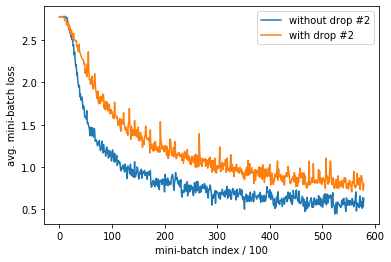

In [61]:
plt.plot(all_losses[1], label='without drop #2')
plt.plot(all_losses[2], label='with drop #2')
plt.legend()
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

### Evaluate on Test Dataset

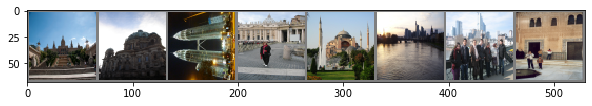

GroundTruth:   6696  1553  5554  9633  8063 10900 10900  9779
Predicted:   6696  6051  5554  9633  8063  6696 10900  9779


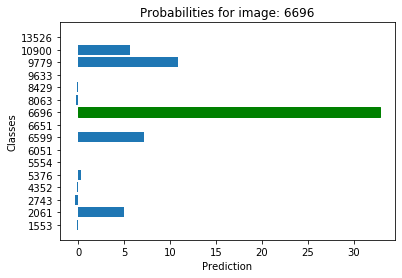

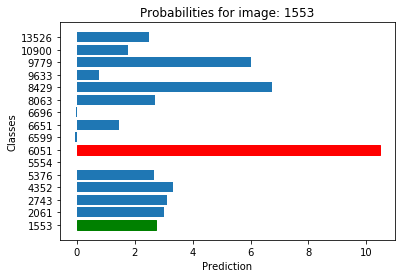

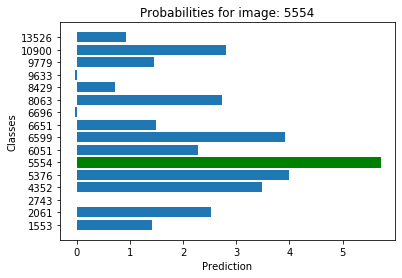

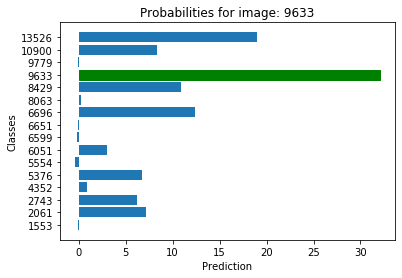

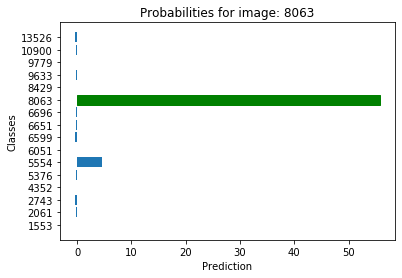

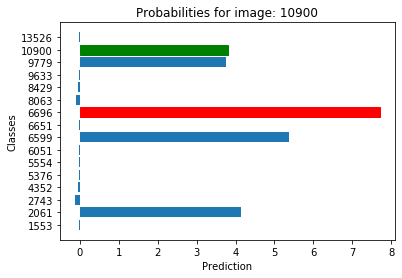

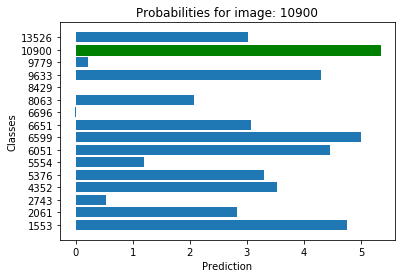

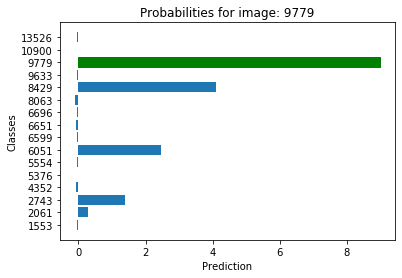

In [48]:
# CODE FROM COGS 181 HW 5 without dropout
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batchSize)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batchSize)))
y_pos = np.arange(len(classes))

for i in range(batchSize):
    bar = plt.barh(y_pos, outputs[i].cpu().data.numpy(), align='center')
    bar[predicted[i]].set_color('r')
    bar[labels[i]].set_color('g')
    plt.yticks(y_pos, classes)
    plt.xlabel('Prediction')
    plt.ylabel('Classes')
    plt.title('Probabilities for image: {}'.format(classes[labels[i]]))
    plt.show()

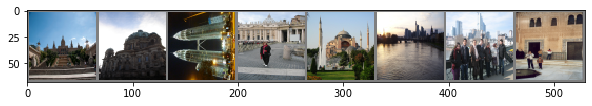

GroundTruth:   6696  1553  5554  9633  8063 10900 10900  9779
Predicted:   6696  2743 13526  9633  8063  6599  6599  9779


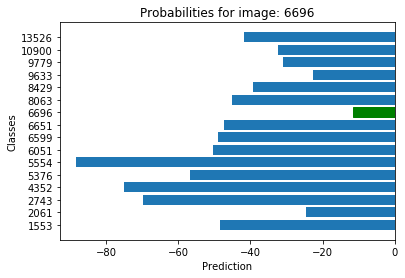

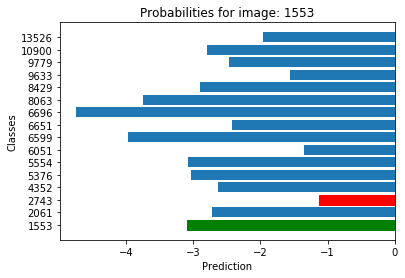

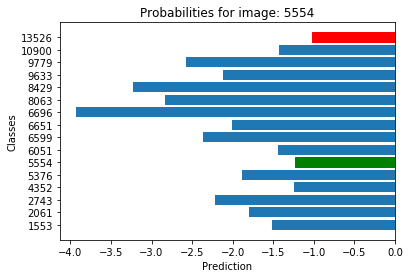

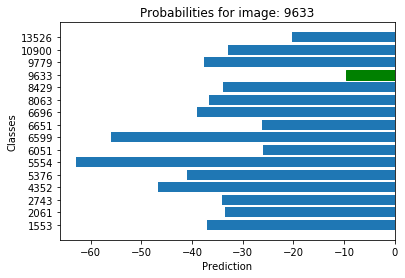

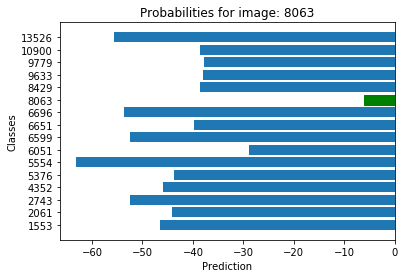

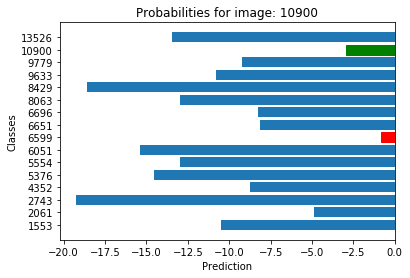

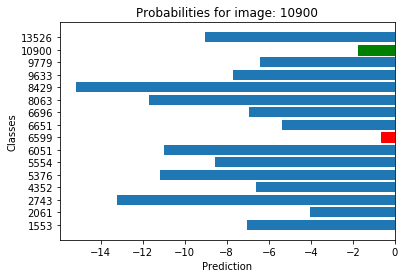

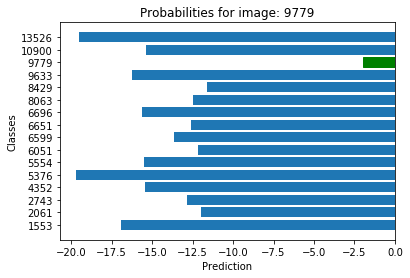

In [58]:
# with dropout
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batchSize)))
outputs = net(images.to(device))
# print(outputs)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batchSize)))
y_pos = np.arange(len(classes))

for i in range(batchSize):
    bar = plt.barh(y_pos, outputs[i].cpu().data.numpy(), align='center')
    bar[predicted[i]].set_color('r')
    bar[labels[i]].set_color('g')
    plt.yticks(y_pos, classes)
    plt.xlabel('Prediction')
    plt.ylabel('Classes')
    plt.title('Probabilities for image: {}'.format(classes[labels[i]]))
    plt.show()

In [59]:
# CODE FROM COGS 181 HW 5 Test accuracy with dropout
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test images: %d %%'.format(len(imagesTest)) % (
    100 * correct / total))

Accuracy of the network on the 11780 test images: 75 %


In [49]:
# CODE FROM COGS 181 HW 5 test accuracy without dropout
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test images: %d %%'.format(len(imagesTest)) % (
    100 * correct / total))

Accuracy of the network on the 11780 test images: 77 %


In [60]:
# CODE FROM COGS 181 HW 5 test accuracy for each class with dropout
class_correct = list(0. for i in range(numClasses))
class_total = list(0. for i in range(numClasses))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if labels.size() == torch.Size([batchSize]): # added this, got a bug from labels not being the right size
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

for i in range(numClasses):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  1553 : 72 %
Accuracy of  2061 : 66 %
Accuracy of  2743 : 88 %
Accuracy of  4352 : 79 %
Accuracy of  5376 : 79 %
Accuracy of  5554 : 85 %
Accuracy of  6051 : 69 %
Accuracy of  6599 : 77 %
Accuracy of  6651 : 69 %
Accuracy of  6696 : 90 %
Accuracy of  8063 : 88 %
Accuracy of  8429 : 77 %
Accuracy of  9633 : 63 %
Accuracy of  9779 : 70 %
Accuracy of 10900 : 40 %
Accuracy of 13526 : 77 %


In [50]:
# CODE FROM COGS 181 HW 5 test accuracy for each class without dropout
class_correct = list(0. for i in range(numClasses))
class_total = list(0. for i in range(numClasses))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if labels.size() == torch.Size([batchSize]): # added this, got a bug from labels not being the right size
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

for i in range(numClasses):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  1553 : 77 %
Accuracy of  2061 : 70 %
Accuracy of  2743 : 90 %
Accuracy of  4352 : 86 %
Accuracy of  5376 : 80 %
Accuracy of  5554 : 85 %
Accuracy of  6051 : 75 %
Accuracy of  6599 : 61 %
Accuracy of  6651 : 76 %
Accuracy of  6696 : 92 %
Accuracy of  8063 : 90 %
Accuracy of  8429 : 87 %
Accuracy of  9633 : 72 %
Accuracy of  9779 : 64 %
Accuracy of 10900 : 65 %
Accuracy of 13526 : 74 %
